# Workshop(Kaggle dataset)


## İçindekiler

* İlgili kütüphanelerin yüklenmesi 
* İlgili datasetin yüklenmesi
* Dataya ilk bakış 
* Ön işleme süreçleri
  * Kategorik ve numerik değişkenlerin tespiti
  * Kategorik değişkenlerin LabelEncoder ile encoding işlemine tabi tutulması.
  * Missing değerlerin tespiti
  * Sürekli değerlerde bulunan missing değerlerin doldurulması
* Train ve test ayırımı(validation için)
  * Modelin default hali ile eğitim süreci(LGBM)
  * Learning curve ile train süreci analizi
  * Modelin Default hali ile eğitim süreci(RidgeClassifier)
  * Learning curve ile train süreci analizi
* LOFO ile feature importance
* SMOTETomek methodu ile datanın balance bir hale dönüştürülmesi
* Hyperparameter tuning LGBM Classifier
* Hyperparameter tuning Ridge Classifier
  * Learning curve ve eğitim süreci analizi

## Görev aşamaları ve çıkarımlar

* Ön işleme için gerekli olan işlemleri hazırlamanı isteyeceğiz.(Var olan çalışmaları kullanabilirsin.)
  * Ön işleme için öncelikle kategorik ve numerik değişkenler tespit edildi, kategorik değişkenler LabelEncoder aracalığı ile encoding işlemine tabi tutuldu.
  * Missing değerler tespit edildi sürekli değerler ilgili column'ın median değeri ile dolduruldu bu datayı data normal bir dağılım içerisine sokmak için yapıldı, sürekli değerlerin fazlalalığı outlier sayımızın fazla olabileceği sebebi ile filling işlemi bu şekilde gerçekleştirildi.

* Model validasyonu için hangi stratejiyi kullanman gerektiğini belirlemeni isteyeceğiz.(KFold, StratifiedKFold vs.)
  * Kfold yöntemi seçildi.

* İlk haliyle basit parametrelerle, modelinin prediction sonuçlarını sunmanı isteyeceğiz.
  * Öğrenim süreci oldukça verimsizdi özellikle test datasının imbalance bir yapıya sahip olmasında 1 labelına karşı duyarlılığı olmayan bir model olduğu gözlendi, over-sampling ve undersampling methodlarının karışımı olan knn algoritmasının çalışma prensibine sahip SMOTOTEK methodu ile data artırımı gidilerek data dengelenmeye çalışıldı ancak feature ve data sayısının fazla olması sebebi ile fazla süre alındığı görülerek bu yoldan vazgeçildi.
  * SMOTE-Tomek kaynakça : *https://towardsdatascience.com/imbalanced-classification-in-python-smote-tomek-links-method-6e48dfe69bbc*

* Feature selection kısmını lofo-importance ile yapmanı isteyeceğiz.
  * LOFO ile featurelarımızın importance_mean ve importance_std(normal dağılımları) ile 10 adet özellik seçildi.
  * Yararlanılan kaynak *https://www.youtube.com/watch?v=zqsQ2ojj7sE*
  
* Hyperparametre optimizasyonunu sunmanı isteyeceğiz.(Grid search, random search veyahut bayesian search)
  * Data büyüklüğü nedeni ile RandomizedSearchCV yöntemi ile hyperparameter tuning gerçekleştirildi, GridSearchCV çok tercih edilen bir yöntem olmadığı bilindiği için.
  * "GridSearchCV vs RandomizedCV?" Machine_Learning_Tutorial repositorysinde farklarını incelediğim bir yazı bulabilirsiniz.

* 3. adımdan, 5.adıma kadarki model geliştirme aşamasında yaptığın tercihlerin performansını nasıl arttırdığını sunmanı isteyeceğiz. Denediğin her bir deneyin artısını eksisini kaydetsen iyi bir geliştirme olur.
  * Öncelikle 3.adımda 122 featureın olması data kontrol etmemiz ve manipüle etmemiz konusunda bize çeşitli sıkıntılar çıkardı, bunlardan bir tanesi ise test datasının dengesiz bir yapıya sahip olması nedeni ile data artırımına gitmeye çalıştık ancak süreç bir hayli sürdüğü için bu amacımızı gerçekleştiremedik dolayısıyla fazlasıyla dengesiz bir model build ettik.
  * LOFO ile 10 feature çıkartarak datayı daha kolay manipüle edebilir hale geldik, işlemlerimiz oldukça hızlandı ve data artırımına optimize bir süre ile giderek dengeli modeller oluşturduk.

# İlgili kütüphanelerin yüklenmesi

In [638]:
# Görselleştirme ve analiz
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')
import warnings 
warnings.filterwarnings('ignore')

# ön işleme 
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek 

# test süreçleri
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV

# modeller
#!pip install lightgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeClassifier
#!pip install lofo-importance
from lofo import LOFOImportance, Dataset, plot_importance

# İlgili datasetin yüklenmesi

In [639]:
# train data 
train_data = pd.read_csv('application_train.csv')
# test data 
test_data = pd.read_csv('application_test.csv')

# Dataya ilk bakış 

In [640]:
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [641]:
test_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [642]:
print(train_data.shape)
print(test_data.shape)

(307511, 122)
(48744, 121)


# Ön işleme süreçleri

### Kategorik ve numerik değişkenlerin tespiti

In [643]:
object_col = (train_data.dtypes == 'object')

# liste halinde object typeına sahip featureların tutulması 
object_list = list(object_col[object_col].index)

In [644]:
object_list

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

* Kategorik değişkenlerin hepsi

In [645]:
for i in object_list:
    
    print(i, train_data[i].isnull().sum())

NAME_CONTRACT_TYPE 0
CODE_GENDER 0
FLAG_OWN_CAR 0
FLAG_OWN_REALTY 0
NAME_TYPE_SUITE 1292
NAME_INCOME_TYPE 0
NAME_EDUCATION_TYPE 0
NAME_FAMILY_STATUS 0
NAME_HOUSING_TYPE 0
OCCUPATION_TYPE 96391
WEEKDAY_APPR_PROCESS_START 0
ORGANIZATION_TYPE 0
FONDKAPREMONT_MODE 210295
HOUSETYPE_MODE 154297
WALLSMATERIAL_MODE 156341
EMERGENCYSTATE_MODE 145755


In [646]:
# continous features 
c = (train_data.dtypes == 'float64')

continous_features = list(c[c].index)

In [647]:
for i in continous_features:
    print(i, train_data[i].isnull().sum())

AMT_INCOME_TOTAL 0
AMT_CREDIT 0
AMT_ANNUITY 12
AMT_GOODS_PRICE 278
REGION_POPULATION_RELATIVE 0
DAYS_REGISTRATION 0
OWN_CAR_AGE 202929
CNT_FAM_MEMBERS 2
EXT_SOURCE_1 173378
EXT_SOURCE_2 660
EXT_SOURCE_3 60965
APARTMENTS_AVG 156061
BASEMENTAREA_AVG 179943
YEARS_BEGINEXPLUATATION_AVG 150007
YEARS_BUILD_AVG 204488
COMMONAREA_AVG 214865
ELEVATORS_AVG 163891
ENTRANCES_AVG 154828
FLOORSMAX_AVG 153020
FLOORSMIN_AVG 208642
LANDAREA_AVG 182590
LIVINGAPARTMENTS_AVG 210199
LIVINGAREA_AVG 154350
NONLIVINGAPARTMENTS_AVG 213514
NONLIVINGAREA_AVG 169682
APARTMENTS_MODE 156061
BASEMENTAREA_MODE 179943
YEARS_BEGINEXPLUATATION_MODE 150007
YEARS_BUILD_MODE 204488
COMMONAREA_MODE 214865
ELEVATORS_MODE 163891
ENTRANCES_MODE 154828
FLOORSMAX_MODE 153020
FLOORSMIN_MODE 208642
LANDAREA_MODE 182590
LIVINGAPARTMENTS_MODE 210199
LIVINGAREA_MODE 154350
NONLIVINGAPARTMENTS_MODE 213514
NONLIVINGAREA_MODE 169682
APARTMENTS_MEDI 156061
BASEMENTAREA_MEDI 179943
YEARS_BEGINEXPLUATATION_MEDI 150007
YEARS_BUILD_MEDI 2044

In [648]:
for i in continous_features:
    train_data[i].fillna(train_data[i].median(), inplace=True)

In [649]:
# filling sürecinin test edilmesi
for i in continous_features:
    print(i, train_data[i].isnull().sum())

AMT_INCOME_TOTAL 0
AMT_CREDIT 0
AMT_ANNUITY 0
AMT_GOODS_PRICE 0
REGION_POPULATION_RELATIVE 0
DAYS_REGISTRATION 0
OWN_CAR_AGE 0
CNT_FAM_MEMBERS 0
EXT_SOURCE_1 0
EXT_SOURCE_2 0
EXT_SOURCE_3 0
APARTMENTS_AVG 0
BASEMENTAREA_AVG 0
YEARS_BEGINEXPLUATATION_AVG 0
YEARS_BUILD_AVG 0
COMMONAREA_AVG 0
ELEVATORS_AVG 0
ENTRANCES_AVG 0
FLOORSMAX_AVG 0
FLOORSMIN_AVG 0
LANDAREA_AVG 0
LIVINGAPARTMENTS_AVG 0
LIVINGAREA_AVG 0
NONLIVINGAPARTMENTS_AVG 0
NONLIVINGAREA_AVG 0
APARTMENTS_MODE 0
BASEMENTAREA_MODE 0
YEARS_BEGINEXPLUATATION_MODE 0
YEARS_BUILD_MODE 0
COMMONAREA_MODE 0
ELEVATORS_MODE 0
ENTRANCES_MODE 0
FLOORSMAX_MODE 0
FLOORSMIN_MODE 0
LANDAREA_MODE 0
LIVINGAPARTMENTS_MODE 0
LIVINGAREA_MODE 0
NONLIVINGAPARTMENTS_MODE 0
NONLIVINGAREA_MODE 0
APARTMENTS_MEDI 0
BASEMENTAREA_MEDI 0
YEARS_BEGINEXPLUATATION_MEDI 0
YEARS_BUILD_MEDI 0
COMMONAREA_MEDI 0
ELEVATORS_MEDI 0
ENTRANCES_MEDI 0
FLOORSMAX_MEDI 0
FLOORSMIN_MEDI 0
LANDAREA_MEDI 0
LIVINGAPARTMENTS_MEDI 0
LIVINGAREA_MEDI 0
NONLIVINGAPARTMENTS_MEDI 0
NONLI

In [650]:
# kategorik değişkenlerin nan drop edilmesi
train_data.dropna(inplace = True)

In [651]:
for i in object_list:
    
    print(i, train_data[i].isnull().sum())

NAME_CONTRACT_TYPE 0
CODE_GENDER 0
FLAG_OWN_CAR 0
FLAG_OWN_REALTY 0
NAME_TYPE_SUITE 0
NAME_INCOME_TYPE 0
NAME_EDUCATION_TYPE 0
NAME_FAMILY_STATUS 0
NAME_HOUSING_TYPE 0
OCCUPATION_TYPE 0
WEEKDAY_APPR_PROCESS_START 0
ORGANIZATION_TYPE 0
FONDKAPREMONT_MODE 0
HOUSETYPE_MODE 0
WALLSMATERIAL_MODE 0
EMERGENCYSTATE_MODE 0


In [652]:
# label encoder ile kategorik değişkenlerin encoding işleminden geçirilmesi

# modelin inşa edilmesi
le = LabelEncoder()

# kategorik değişkenlerin encoding işleminden geçirilmesi
for i in object_list:
    
    # train datasının encoding işlemi
    train_data[i] = le.fit_transform(train_data[i])
    
    # test datasının encoding işlemi 
    test_data[i] = le.fit_transform(test_data[i])

In [653]:
# encoding işleminin kontrol edilmesi 
object_test = (train_data.dtypes == 'object')

In [654]:
object_test.sum()

0

In [655]:
test_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


* Label Encoding uygulandı.

In [656]:
train_data.shape

(65789, 122)

# Train ve test ayırımı(validation için)

In [657]:
X = train_data.drop('TARGET' , axis = 1)
X.shape

(65789, 121)

In [658]:
y = train_data['TARGET']
y.shape

(65789,)

In [659]:
# train and test splitting 
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.3 , random_state = 42)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:',y_test.shape)

X_train shape: (46052, 121)
y_train shape: (46052,)
X_test.shape: (19737, 121)
y_test.shape: (19737,)


# Modelin default hali ile eğitim süreci(LGBM)

In [595]:
lgbm = LGBMClassifier()

In [596]:
accuracies = cross_val_score(estimator = lgbm , X = X_train, y = y_train, cv = 5)
print('Ortalama validation skoru:{}'.format(np.mean(accuracies)))
print('Skorlarin dağılımının incelenmesi:{}'.format(np.std(accuracies)))

Ortalama validation skoru:0.9247155415720545
Skorlarin dağılımının incelenmesi:0.00018821391951218995


* Normal dağılım ve ortalama validation skorumuz ile verimli bir eğitim süreci geçtiğini görmekteyiz.

### Learning curve ile train süreci analizi

In [25]:
# test datası ile eğitim 
lgbm.fit(X_train, y_train)
print(lgbm.score(X_test, y_test))
lgbm_predict = lgbm.predict(X_test)
Counter(lgbm_predict)

0.9210112985762781


Counter({0: 19684, 1: 53})

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     18191
           1       0.38      0.01      0.03      1546

    accuracy                           0.92     19737
   macro avg       0.65      0.51      0.49     19737
weighted avg       0.88      0.92      0.89     19737



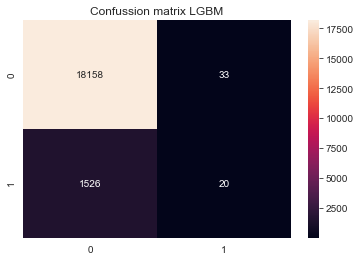

In [26]:
print(classification_report(y_test, lgbm_predict)) 

# Confusion Matrix
cm = confusion_matrix(y_test, lgbm_predict)
sns.heatmap(cm, annot = True , fmt = '0.0f')
plt.title('Confussion matrix LGBM')
plt.show()

* Görüldüğü üzre fazlasıyla 1 labelı adına duyarsız bir model.

In [27]:
X_train.shape

(46052, 121)

In [28]:
from sklearn.model_selection import learning_curve
# for train sizes list
train_sizes = [1, 500, 2000, 4000, 8000, 20000, 41446]

train_sizes, train_score, validation_score = learning_curve(LGBMClassifier(), 
                                                            X_train, y_train, cv = 10, scoring = 'accuracy', 
                                                            train_sizes = train_sizes)
print(train_score)
print('-' * 70)
print(validation_score)

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [0.983625   0.985625   0.98775    0.98775    0.98775    0.98775
  0.98775    0.98775    0.98775    0.98775   ]
 [0.9421     0.94135    0.9418     0.9399     0.9416     0.94305
  0.94305    0.94305    0.94305    0.94305   ]
 [0.93167012 0.9310428  0.93188728 0.93111519 0.93188728 0.93154949
  0.93154949 0.93188728 0.9320803  0.93159774]]
----------------------------------------------------------------------
[[0.92531481 0.9250977  0.92529859 0.92529859 0.92529859 0.92529859
  0.92529859 0.92529859 0.92529859 0.92529859]
 [0.92553191 0.92379505 0.92421281 0.92399566 

* Training ve validation skorlarımızı görmekteyiz son değerlere baktığımız zaman bir bayes farkı gözlemlemekteyiz.

In [32]:
train_mean = np.mean(train_score, axis = 1)
train_mean

array([1.        , 1.        , 1.        , 1.        , 0.987125  ,
       0.9422    , 0.93162669])

In [33]:
validation_mean = np.mean(validation_score, axis = 1)
validation_mean

array([0.92528012, 0.92443324, 0.92441152, 0.92395555, 0.92417268,
       0.92454181, 0.92491098])

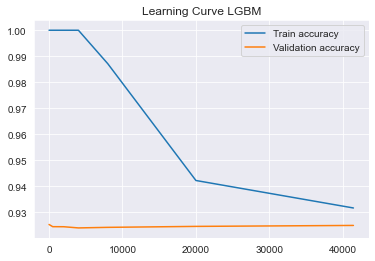

In [34]:
plt.plot(train_sizes, train_mean, label = 'Train accuracy')
plt.plot(train_sizes, validation_mean, label = 'Validation accuracy')
plt.legend(loc = 'best')
plt.title('Learning Curve LGBM')
plt.show()

* Training sürecine ait ciddi bir bayes farkı bulunmakta ideal bir öğrenim sürecinden uzak bir model.
* Hyperparameter tuning ve feature engineering optimize edilmesi gerekmekte

### Modelin Default hali ile eğitim süreci(RidgeClassifier)

In [35]:
rc = RidgeClassifier()

In [38]:
accuracies = cross_val_score(estimator = rc , X = X_train, y = y_train, cv = 5)
print('Ortalama validation skoru:{}'.format(np.mean(accuracies)))
print('Skorlarin dağılımının incelenmesi:{}'.format(np.std(accuracies)))

Ortalama validation skoru:0.9252366882772817
Skorlarin dağılımının incelenmesi:5.399475441249208e-05


* Ortalama skorumuz ve skorların normal dağılımı gayet iyi gözüküyor.

### Learning curve ile train süreci analizi

In [39]:
rc.fit(X_train, y_train)
print(rc.score(X_test, y_test))

0.9216699599736535


In [40]:
rc_predict = rc.predict(X_test)

In [41]:
rc_predict
Counter(rc_predict)

Counter({0: 19737})

* Datamız tahminleme yaparken 1 labelı minotry class konumuna düşmüş ve test datası içerisinde 1 labelı için tahmin yapamamıştır. Dolayısı ile confussion matrix ve f1 skorlarına bakmamıza gerek yoktur. 
* Bu konu da over-sampling ve under-sampling methodları veya daya farklı methodlar ile data artırımına özelllik sayısı ve data sayısı sebebi ile gidebilmek zaman açısından fazlasıyla zor dolayısı ile LOFO ile feature importance yaptıktan sonra, data artırımına gitme denenebilir.

In [42]:
from sklearn.model_selection import learning_curve
# for train sizes list
train_sizes = [1, 500, 2000, 4000, 8000, 20000, 41446]

train_sizes, train_score, validation_score = learning_curve(RidgeClassifier(), 
                                                            X, y, cv = 10, scoring = 'accuracy', 
                                                           train_sizes = train_sizes)
print(train_score)
print('-' * 70)
print(validation_score)

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [0.938      0.922      0.922      0.922      0.922      0.922
  0.922      0.922      0.922      0.922     ]
 [0.924      0.9235     0.9235     0.9235     0.9235     0.9235
  0.9235     0.9235     0.9235     0.9235    ]
 [0.92725    0.9225     0.9225     0.9225     0.9225     0.9225
  0.9225     0.9225     0.9225     0.9225    ]
 [0.92575    0.92575    0.92475    0.92475    0.92475    0.92475
  0.92475    0.92475    0.92475    0.92475   ]
 [0.9239     0.9239     0.92395    0.9239     0.92475    0.92475
  0.92475    0.92475    0.92475    0.92475   ]
 [0.92312889 0.92315302 0.92312889 0.92312889 0.92312889 0.92312889
  0.92315302 0.92378034 0.92378034 0.92378034]]
----------------------------------------------------------------------
[[0.92415261 0.07584739 0.07584739 0.07584739 0.07584739 0.07584739
  0.07584739 0.07569539 0.07569539 0.0757069 ]
 [0.92384861 0.09408725 0.07584739 

In [43]:
train_mean = np.mean(train_score, axis = 1)
train_mean

array([1.        , 0.9236    , 0.92355   , 0.922975  , 0.92495   ,
       0.924415  , 0.92332915])

In [44]:
validation_mean = np.mean(validation_score, axis = 1)
validation_mean

array([0.16063347, 0.16242705, 0.92416666, 0.92412106, 0.92412105,
       0.92415146, 0.92415146])

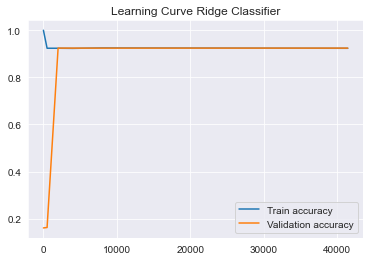

In [45]:
plt.plot(train_sizes, train_mean, label = 'Train accuracy')
plt.plot(train_sizes, validation_mean, label = 'Validation accuracy')
plt.legend(loc = 'best')
plt.title('Learning Curve Ridge Classifier')
plt.show()

* Tanımlaamayan ve validation 

# LOFO ile feature importance

In [46]:
# lofo toolunun kurulumu
#!pip install lofo-importance

In [47]:
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
13,100017,0,0,1,1,0,1,225000.0,918468.0,28966.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
14,100018,0,0,0,0,1,0,189000.0,773680.5,32778.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
18,100022,0,1,0,0,1,0,112500.0,157500.0,7875.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
from sklearn.model_selection import KFold

sample_df = train_data.sample(frac=0.01, random_state=42)
sample_df.sort_values("SK_ID_CURR", inplace=True)

cv = KFold(n_splits=4, shuffle=True, random_state=42)

sample_df.shape

(658, 122)

In [49]:
from lofo import LOFOImportance, Dataset, plot_importance
target = "TARGET"
features = [col for col in train_data.columns if col != target]

In [29]:
features

['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEAR

In [30]:
dataset = Dataset(df = sample_df, target="TARGET", features=[col for col in train_data.columns if col != target])

In [31]:
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc")

In [32]:
importance_df = lofo_imp.get_importance()

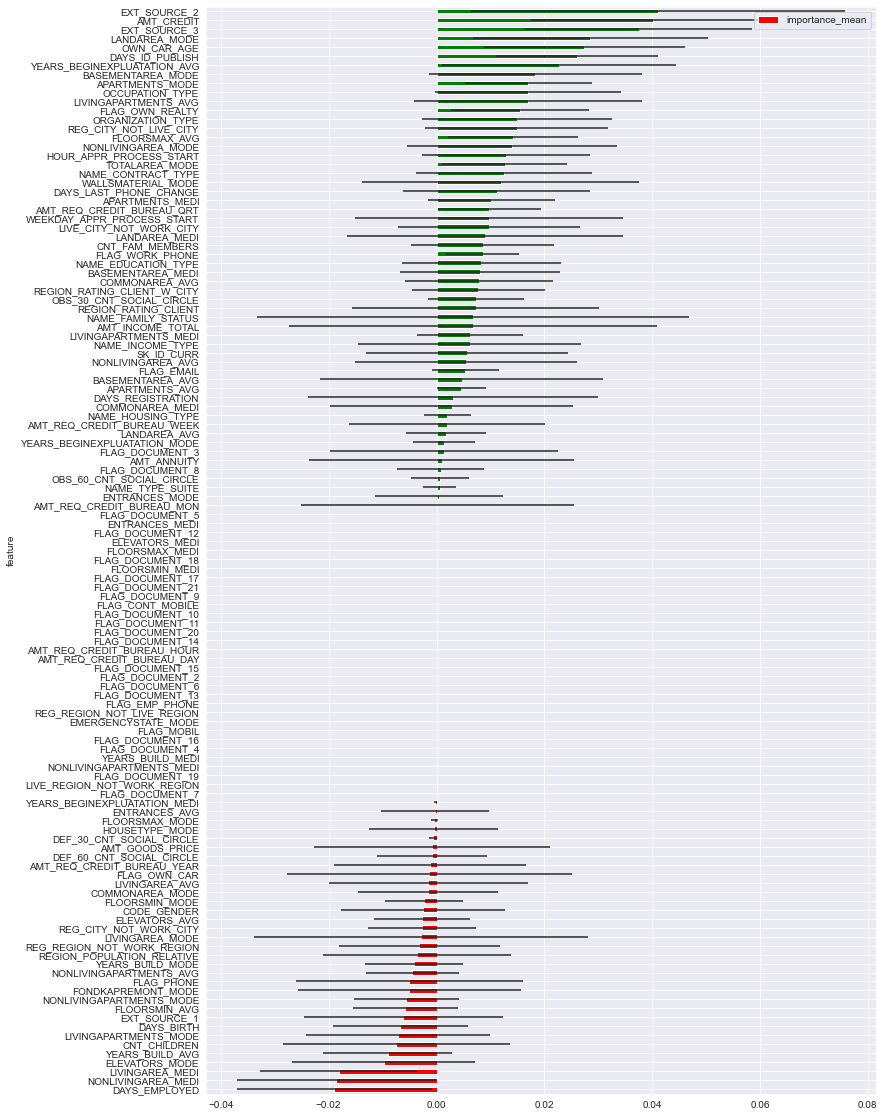

In [34]:
plot_importance(importance_df, figsize=(12, 20))

* Gördüğümüz üzre LOFO ile siyah bar ile featureın normal dağılımını kırmızı ve yeşil barlar ile ise 'importance_mean' değerini görselleştirmekteyiz.

*kaynak: https://www.youtube.com/watch?v=zqsQ2ojj7sE*

In [35]:
importance_df.head(10)

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3
41,EXT_SOURCE_2,0.041126,0.034706,0.003981,0.098065,0.031584,0.030872
7,AMT_CREDIT,0.040096,0.022622,0.026274,0.056129,0.067244,0.010738
42,EXT_SOURCE_3,0.037486,0.021050,0.004777,0.049677,0.034641,0.060850
66,LANDAREA_MODE,0.028526,0.021761,0.051752,0.006452,0.007132,0.048770
20,OWN_CAR_AGE,0.027397,0.018644,0.040605,0.001935,0.017830,0.049217
19,DAYS_ID_PUBLISH,0.026095,0.015039,0.011943,0.039355,0.042792,0.010291
45,YEARS_BEGINEXPLUATATION_AVG,0.022704,0.021737,0.034236,-0.005161,0.051452,0.010291
58,BASEMENTAREA_MODE,0.018310,0.019764,0.035032,0.040645,0.002038,-0.004474
57,APARTMENTS_MODE,0.017054,0.011841,0.018312,0.018710,-0.001019,0.032215
27,OCCUPATION_TYPE,0.017021,0.017286,0.006369,0.045161,0.000000,0.016555


In [36]:
importance_df.tail()

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3
46,YEARS_BUILD_AVG,-0.009071,0.011973,-0.029459,-5.806452e-03,-0.001019,0.000000
62,ELEVATORS_MODE,-0.009806,0.016985,0.000000,0.000000e+00,-0.039226,0.000000
82,LIVINGAREA_MEDI,-0.018170,0.014535,-0.004777,-4.516129e-03,-0.039226,-0.024161
84,NONLIVINGAREA_MEDI,-0.018629,0.018443,-0.029459,-5.161290e-03,0.003057,-0.042953
17,DAYS_EMPLOYED,-0.018938,0.018128,-0.040605,1.110223e-16,-0.002038,-0.033110


In [37]:
# pd series ile importance_mean ve importance_std değerlerinin değerlendirilmesi
feature_importance = importance_df.head(10).feature

In [38]:
feature_importance

41                   EXT_SOURCE_2
7                      AMT_CREDIT
42                   EXT_SOURCE_3
66                  LANDAREA_MODE
20                    OWN_CAR_AGE
19                DAYS_ID_PUBLISH
45    YEARS_BEGINEXPLUATATION_AVG
58              BASEMENTAREA_MODE
57                APARTMENTS_MODE
27                OCCUPATION_TYPE
Name: feature, dtype: object

* Eğitim sürecinde kullanacağımız özellikler.

In [660]:
feature_imp_list = list(['EXT_SOURCE_2', 'AMT_CREDIT', 'EXT_SOURCE_3', 
                         'LANDAREA_MODE', 
                         'OWN_CAR_AGE', 'DAYS_ID_PUBLISH', 'YEARS_BEGINEXPLUATATION_AVG', 'BASEMENTAREA_MODE', 'APARTMENTS_MODE',
                        'OCCUPATION_TYPE'])

In [661]:
feature_imp_list

['EXT_SOURCE_2',
 'AMT_CREDIT',
 'EXT_SOURCE_3',
 'LANDAREA_MODE',
 'OWN_CAR_AGE',
 'DAYS_ID_PUBLISH',
 'YEARS_BEGINEXPLUATATION_AVG',
 'BASEMENTAREA_MODE',
 'APARTMENTS_MODE',
 'OCCUPATION_TYPE']

In [662]:
# datanın lofo ile filtrelenmesi
data_importance = train_data[['EXT_SOURCE_2', 'AMT_CREDIT', 'EXT_SOURCE_3', 
                              'LANDAREA_MODE', 
                              'OWN_CAR_AGE', 'DAYS_ID_PUBLISH', 'YEARS_BEGINEXPLUATATION_AVG', 
                              'BASEMENTAREA_MODE', 'APARTMENTS_MODE',
                              'OCCUPATION_TYPE']]

In [663]:
data_importance.shape

(65789, 10)

In [664]:
y.shape

(65789,)

In [665]:
# concat işlemi labellar ve feature importance sonrası data ile birleştirildi
data_importance = pd.concat([data_importance, y], axis = 1)

In [666]:
# concat işlemi kontrolü
data_importance.head()

,EXT_SOURCE_2,AMT_CREDIT,EXT_SOURCE_3,LANDAREA_MODE,OWN_CAR_AGE,DAYS_ID_PUBLISH,YEARS_BEGINEXPLUATATION_AVG,BASEMENTAREA_MODE,APARTMENTS_MODE,OCCUPATION_TYPE,TARGET
0,0.262949,406597.5,0.139376,0.0377,9.0,-2120,0.9722,0.0383,0.0252,8,1
1,0.622246,1293502.5,0.535276,0.0128,9.0,-291,0.9851,0.0538,0.0924,3,0
13,0.566907,918468.0,0.770087,0.0952,23.0,-4911,0.9806,0.1010,0.1502,4,0
14,0.642656,773680.5,0.535276,0.1798,9.0,-2056,0.9985,0.1386,0.3561,8,0
18,0.706428,157500.0,0.556727,0.0286,9.0,-1259,0.9881,0.0640,0.0284,8,0


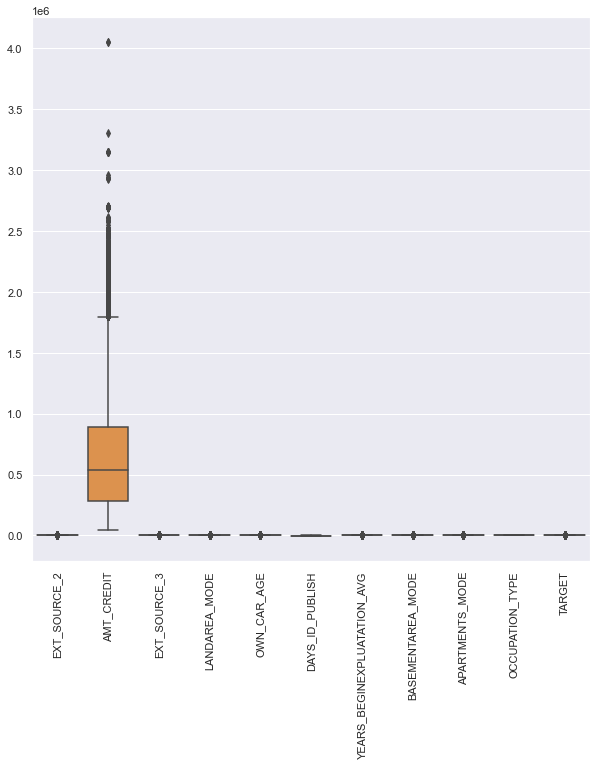

In [667]:
# outlier tespiti 
fig, axes = plt.subplots(figsize=(10, 10), sharey=True)
sns.boxplot(data = data_importance)
plt.xticks(rotation = 90)
plt.show()

* AMT_CREDİT featureunda fazla sayıda outlier görmekteyiz. Bu outlierlar öğrenim sürecinde bizlere epey zorluk çıkaracaktır.

In [668]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # ilk çeyrek
        Q1 = np.percentile(df[c],25)
        # ikinci çeyrek
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier adımı
        outlier_step = IQR * 1.5
        # outlier tespti ve ilgili indexin depolanması
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # indexlerin depolanması
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    
    return outlier_indices

In [669]:
data_importance.loc[detect_outliers(data_importance,['EXT_SOURCE_2', 'AMT_CREDIT', 'EXT_SOURCE_3','LANDAREA_MODE', 
                                              'OWN_CAR_AGE', 'DAYS_ID_PUBLISH', 'YEARS_BEGINEXPLUATATION_AVG', 
                                              'BASEMENTAREA_MODE', 'APARTMENTS_MODE',
                                              'OCCUPATION_TYPE'])]

,EXT_SOURCE_2,AMT_CREDIT,EXT_SOURCE_3,LANDAREA_MODE,OWN_CAR_AGE,DAYS_ID_PUBLISH,YEARS_BEGINEXPLUATATION_AVG,BASEMENTAREA_MODE,APARTMENTS_MODE,OCCUPATION_TYPE,TARGET
61,0.026541,1080000.0,0.434733,0.1173,9.0,-586,0.9856,0.0991,0.0945,14,0
103,0.047291,808650.0,0.406617,0.0965,9.0,-596,0.9990,0.2108,0.2174,3,0
160,0.010272,263844.0,0.535276,0.0117,9.0,-339,0.9727,0.0000,0.0084,14,0
176,0.046216,808650.0,0.549597,0.0979,9.0,-1210,0.9856,0.1819,0.1418,8,0
211,0.044021,495216.0,0.243186,0.0542,9.0,-126,0.9826,0.0886,0.0588,8,1
...,...,...,...,...,...,...,...,...,...,...,...
305578,0.697734,660469.5,0.812823,0.1115,9.0,-4173,0.9846,0.0746,0.4506,11,0
305753,0.478623,900000.0,0.427657,0.1376,9.0,-2318,0.9871,0.1828,0.3361,10,0
306011,0.420265,117162.0,0.824595,0.1154,9.0,-758,0.9846,0.0757,0.2857,8,0
306228,0.663929,254700.0,0.535276,0.0355,9.0,-2495,0.9781,0.1931,0.3015,17,0


* Görüldüğü üzre outlier değerlerimizin bulunduğu indeksleri görüntülemekteyiz.

In [670]:
data_importance = data_importance.drop(detect_outliers(data_importance,['EXT_SOURCE_2', 'AMT_CREDIT', 'EXT_SOURCE_3','LANDAREA_MODE', 
                                              'OWN_CAR_AGE', 'DAYS_ID_PUBLISH', 'YEARS_BEGINEXPLUATATION_AVG', 
                                              'BASEMENTAREA_MODE', 'APARTMENTS_MODE',
                                              'OCCUPATION_TYPE']),axis = 0).reset_index(drop = True)

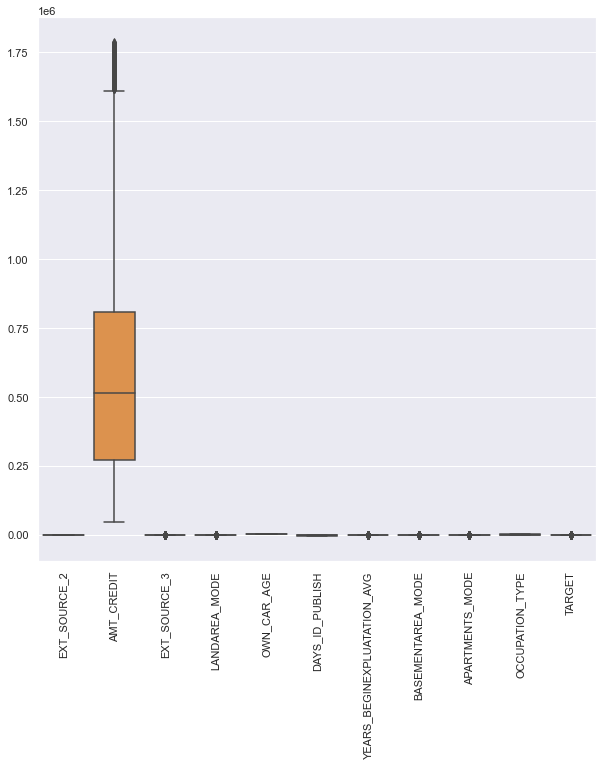

In [671]:
# drop edilen outlierların kontrol edilmesi
fig, axes = plt.subplots(figsize=(10, 10), sharey=True)
sns.boxplot(data = data_importance)
plt.xticks(rotation = 90)
plt.show()

In [672]:
data_importance.shape

(35525, 11)

In [673]:
# scaleing data 
data_features = data_importance.columns

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# scaling data 
data_importance['AMT_CREDIT'] = sc.fit_transform(data_importance['AMT_CREDIT'].values.reshape(-1,1))
data_importance['EXT_SOURCE_2'] = sc.fit_transform(data_importance['EXT_SOURCE_2'].values.reshape(-1,1))
data_importance['EXT_SOURCE_3'] = sc.fit_transform(data_importance['EXT_SOURCE_3'].values.reshape(-1,1))
data_importance['LANDAREA_MODE'] = sc.fit_transform(data_importance['LANDAREA_MODE'].values.reshape(-1,1))
data_importance['OWN_CAR_AGE'] = sc.fit_transform(data_importance['OWN_CAR_AGE'].values.reshape(-1,1))
data_importance['DAYS_ID_PUBLISH'] = sc.fit_transform(data_importance['DAYS_ID_PUBLISH'].values.reshape(-1,1))
data_importance['YEARS_BEGINEXPLUATATION_AVG'] = sc.fit_transform(data_importance['YEARS_BEGINEXPLUATATION_AVG'].values.reshape(-1,1))
data_importance['BASEMENTAREA_MODE'] = sc.fit_transform(data_importance['BASEMENTAREA_MODE'].values.reshape(-1,1))
data_importance['OCCUPATION_TYPE'] = sc.fit_transform(data_importance['OCCUPATION_TYPE'].values.reshape(-1,1))

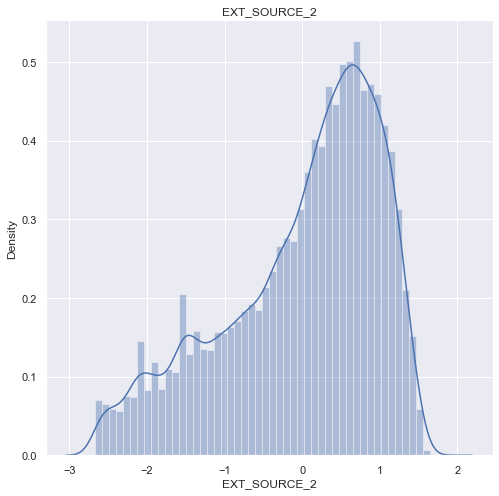

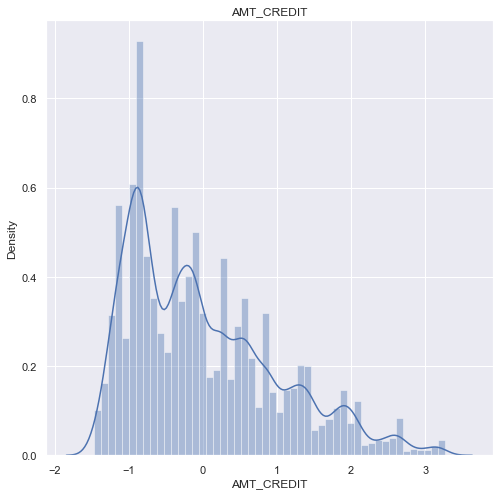

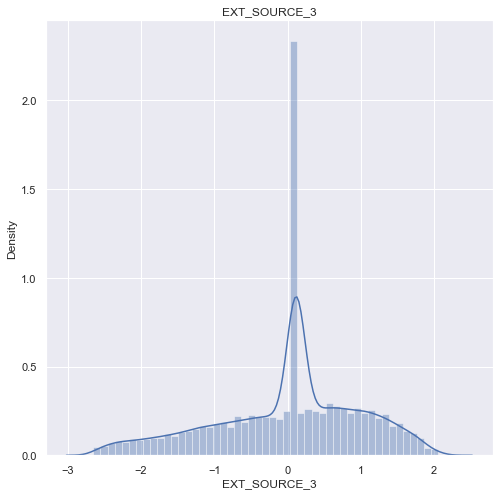

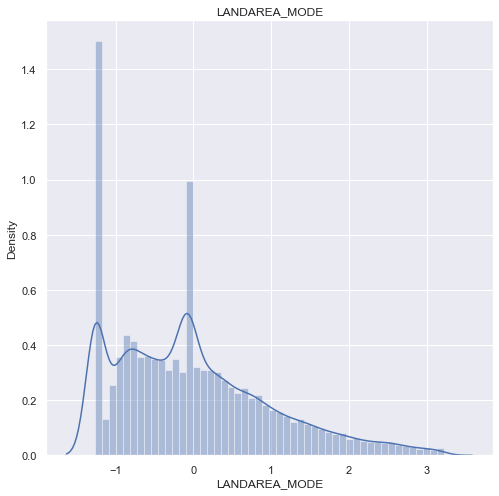

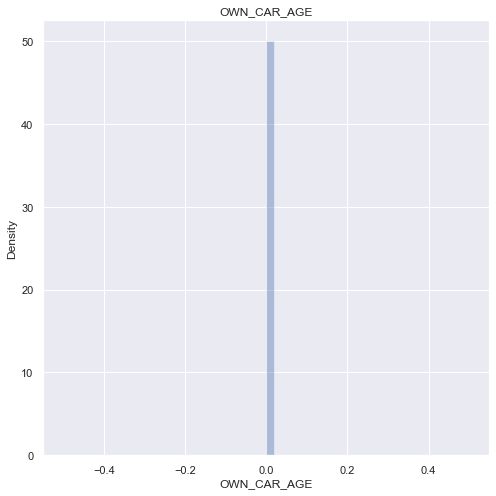

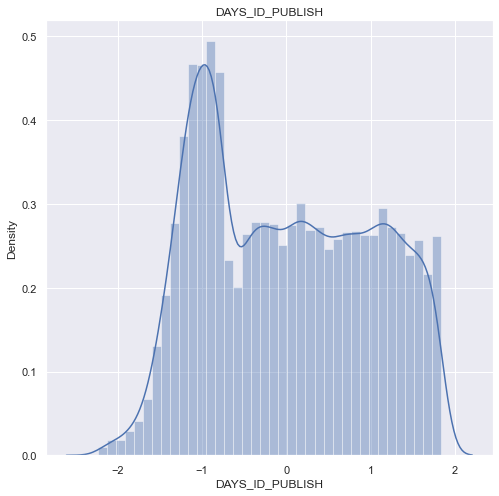

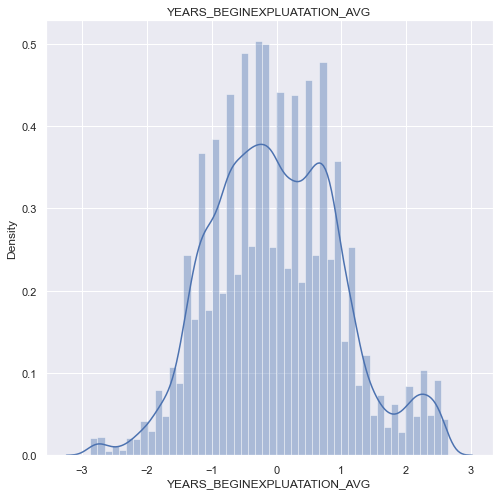

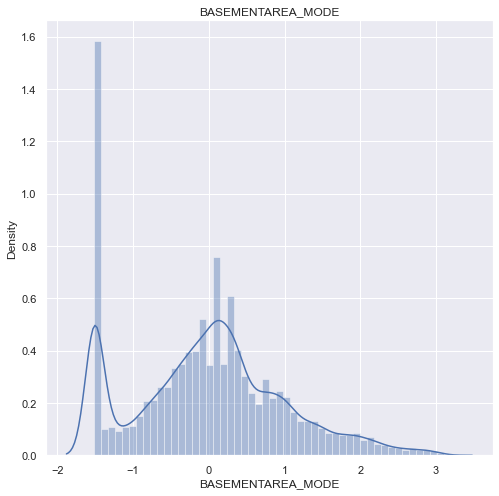

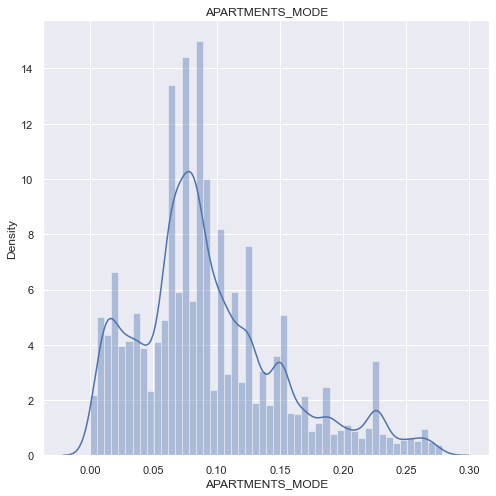

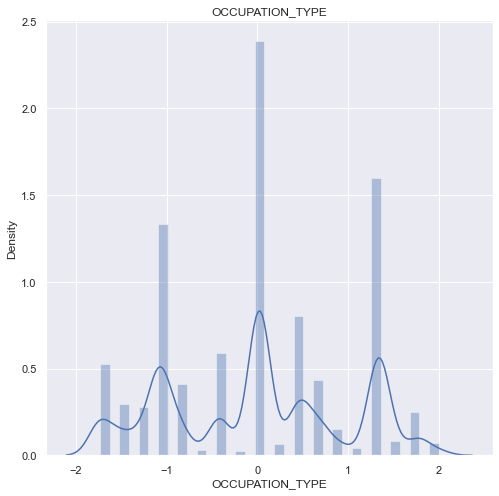

In [675]:
for i in feature_imp_list:
    sns.distplot(data_importance['{}'.format(i)])
    plt.title('{}'.format(i))
    plt.show()

In [676]:
data_importance.drop(['OWN_CAR_AGE'], axis = 1, inplace = True)

* Görüldüğü üzre scaling işlemi ile dataların normal dağılımlarını 0'a çekebildik.
* OWN_CAR_AGE featurenda yüksek ihtimalle fazla sayıda outlier var diyebiliriz

In [677]:
data_importance.head()

,EXT_SOURCE_2,AMT_CREDIT,EXT_SOURCE_3,LANDAREA_MODE,DAYS_ID_PUBLISH,YEARS_BEGINEXPLUATATION_AVG,BASEMENTAREA_MODE,APARTMENTS_MODE,OCCUPATION_TYPE,TARGET
0,-1.534899,-0.487614,-2.203967,-0.289702,0.445872,-1.411974,-0.680481,0.0252,0.022263,1
1,0.502203,1.923216,0.117096,-0.934544,1.644679,0.473259,-0.344697,0.0924,-1.075891,0
2,0.979491,-1.164723,0.242859,-0.525367,1.010209,0.911685,-0.123730,0.0284,0.022263,0
3,-0.433878,-0.240464,-0.916652,1.111341,0.185005,-0.476665,0.277043,0.0924,1.340047,0
4,0.667530,-0.981241,-0.315539,0.052142,-0.060787,-0.549736,-1.178740,0.0735,-1.515152,0


In [678]:
# outlierları çıkarılmış datanın X ve y değişken tanımlamaları
X = data_importance.drop('TARGET', axis = 1)
y = data_importance['TARGET']

In [679]:
# feature importance sonrası train datası ile train-test local splitting 
X_train_importance, X_test_importance, y_train_importance, y_test_importance = train_test_split(X, y, 
                                                                                                test_size = 0.2, 
                                                                                                random_state = 42)

In [680]:
from collections import Counter
Counter(y_test_importance)

Counter({0: 6537, 1: 568})

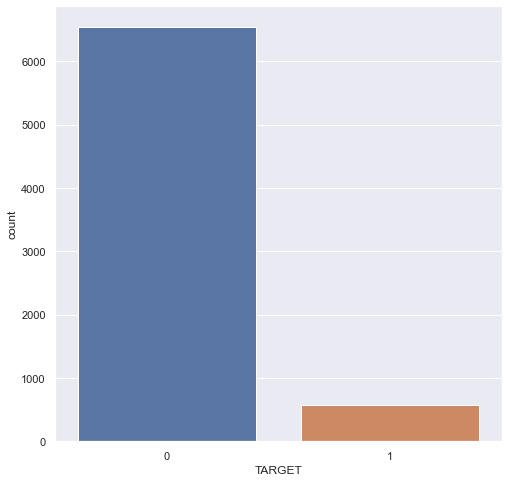

In [681]:
sns.countplot(y_test_importance)
plt.show()

* Görüldüğü üzere imbalance bir yapıya sahibiz.

### SMOTETomek methodu ile datanın balance bir hale dönüştürülmesi

In [364]:
from imblearn.combine import SMOTETomek 
sm = SMOTETomek(random_state = 42) 

X, y = sm.fit_resample(X,y.ravel())

In [365]:
X_train_importance, X_test_importance, y_train_importance, y_test_importance = train_test_split(X, y, 
                                                                                                test_size = 0.2, 
                                                                                                random_state = 42, stratify = y)

In [366]:
Counter(y_test_importance)

Counter({0: 6531, 1: 6530})

<AxesSubplot:ylabel='count'>

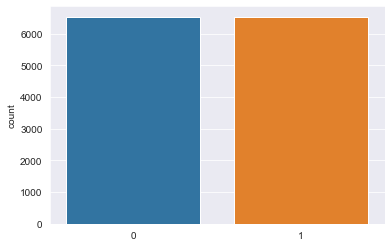

In [367]:
sns.countplot(y_test_importance)

* Test datamız tamamiyle balance bir hale geldi

In [368]:
print('X_train_importance.shape: ', X_train_importance.shape)
print('X_test_importance.shape', X_test_importance.shape)
print('y_train_importance.shape', y_train_importance.shape)
print('y_test_importance.shape', y_test_importance.shape)

X_train_importance.shape:  (52243, 9)
X_test_importance.shape (13061, 9)
y_train_importance.shape (52243,)
y_test_importance.shape (13061,)


## Hyperparameter tuning LGBM Classifier

In [370]:
from sklearn.model_selection import RandomizedSearchCV

grid = {'num_leaves': [27, 31, 61, 81, 127, 197, 231, 275, 302],
        'bagging_fraction': [0.5, 0.7, 0.8, 0.9],
        'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5],
        'min_data': [300, 400, 450, 500, 550, 650],
        'is_unbalance': [True, False],
        'max_bin': [3, 5, 10, 12, 18, 20, 22],
        'boosting_type' : ['gbdt', 'dart'],
        'bagging_freq': [3, 9, 11, 15, 17, 23, 31],
        'max_depth': [3, 4, 5, 6, 7, 9, 11] }

rs = RandomizedSearchCV(lgbm , grid , cv = 10)
rs.fit(X_train_importance, y_train_importance)

print('Best hyperparameter is : {}'.format(rs.best_params_))
print('Best validation score is : {}'.format(rs.best_score_))

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=300. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=300. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=300. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=450. Current value: min_data_in_leaf=450
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=450. Current value: min_data_in_leaf=450
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=450. Current value: min_data_in_leaf=450
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=450. Current value: min_data_in_leaf=450
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=450. Current value: min_data_in_leaf=450
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=450. Current value: min_data_in_leaf=450
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0

* Uzun bir CPU time sonucunda en uygun parameterleri görebilmekteyiz.

Best hyperparameters are : {'num_leaves': 231, 'min_data': 500, 'max_depth': 9, 'max_bin': 18, 'learning_rate': 0.5, 'is_unbalance': False, 'boosting_type': 'gbdt', 'bagging_freq': 15, 'bagging_fraction': 0.9}
Best validation score is : 0.8076001209043291

In [371]:
lgbm = LGBMClassifier(num_leaves = 81, min_data = 300, max_depth = 9, max_bin = 18, learning_rate = 0.1, 
                      is_unbalance = False, boosting_type = 'gbdt', bagging_freq = 9, bagging_fraction = 0.8)

lgbm.fit(X_train_importance, y_train_importance)
print('LGBM Acc:' , lgbm.score(X_test_importance, y_test_importance))
lgbm_predict_balance = lgbm.predict(X_test_importance)

Counter(lgbm_predict_balance)

LGBM Acc: 0.7925886226169512


Counter({0: 6458, 1: 6603})

### Learning curve ve eğitim süreci analizi

In [372]:
print(classification_report(lgbm_predict_balance, y_test_importance))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      6458
           1       0.80      0.79      0.79      6603

    accuracy                           0.79     13061
   macro avg       0.79      0.79      0.79     13061
weighted avg       0.79      0.79      0.79     13061



* Görüldüğü üzre daha az zaman ile minotry classdan kurtulduk aynı zamanda modelimiz gayet verimli bir duyarlılığa sahip.

In [374]:
from sklearn.model_selection import learning_curve
# for train sizes list
train_sizes = [1, 500, 2000, 4000, 8000, 20000, 47018]

train_sizes, train_score, validation_score = learning_curve(lgbm, X_train_importance, y_train_importance, 
                                                            cv = 10, scoring = 'accuracy', 
                                                            train_sizes = train_sizes)
print(train_score)
print('-' * 70)
print(validation_score)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=300. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=300. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=300. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=300. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=300. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=300. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[

In [375]:
train_mean = np.mean(train_score, axis = 1)
train_mean

array([       nan, 0.5192    , 0.6916    , 0.7307    , 0.7707    ,
       0.793095  , 0.81289081])

In [376]:
validation_mean = np.mean(validation_score, axis = 1)
validation_mean

array([       nan, 0.50000957, 0.66774514, 0.70317573, 0.73941014,
       0.76779678, 0.7921828 ])

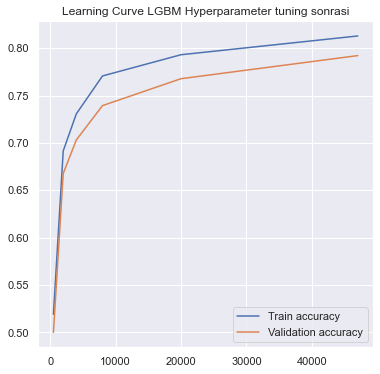

In [377]:
sns.set(rc={'figure.figsize':(6 , 6)})
plt.plot(train_sizes, train_mean, label = 'Train accuracy')
plt.plot(train_sizes, validation_mean, label = 'Validation accuracy')
plt.legend(loc = 'best')
plt.title('Learning Curve LGBM Hyperparameter tuning sonrasi')
plt.show()

* Öğrenim süreci daha dengeli bir hale geldi.
* Daha optimize bir öğrenim süreci geçirdik.
* Ancak ciddi oranda bir bayes farkı gözlemlemekteyiz

# Hyperparameter tuning RİDGE Classifier

In [379]:
rc = RidgeClassifier()

In [380]:
# hyperparameters 
grid = {'alpha': [1.0, 4.0, 16.0],
        'fit_intercept': [True, False],
        'normalize':  [True, False],
        'copy_X': [True, False],
        'class_weight': ['dict','balanced'],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

# hyperparameters tuning
rs = RandomizedSearchCV(rc , grid , cv = 10)
rs.fit(X_train_importance, y_train_importance)
print('Best hyperparameter is : {}'.format(rs.best_params_))
print('Best validation score is : {}'.format(rs.best_score_))

Best hyperparameter is : {'solver': 'auto', 'normalize': False, 'fit_intercept': False, 'copy_X': True, 'class_weight': 'balanced', 'alpha': 16.0}
Best validation score is : 0.643741842947896


### Learning curve ve eğitim süreci analizi

In [381]:
rc = RidgeClassifier(solver = 'auto', normalize = True, fit_intercept = False, 
                     copy_X = True, 
                     class_weight = 'balanced', alpha = 16.0)

rc.fit(X_train_importance, y_train_importance)
print(rc.score(X_test_importance, y_test_importance))
rc_prediction_balance = rc.predict(X_test_importance)
Counter(rc_prediction_balance)

0.6431360539009264


Counter({0: 6738, 1: 6323})

* Tahminleme dengeli bir şekilde gerçeklendi.

In [382]:
print(classification_report(rc_prediction_balance, y_test_importance))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65      6738
           1       0.63      0.65      0.64      6323

    accuracy                           0.64     13061
   macro avg       0.64      0.64      0.64     13061
weighted avg       0.64      0.64      0.64     13061



* Görüldüğü üzre keskinlik ve duyarlılığımız çok daha dengeli bir şekilde.

In [391]:
from sklearn.model_selection import learning_curve
# for train sizes list
train_sizes = [100, 500, 2000, 4000, 8000, 20000, 47018]

train_sizes, train_score, validation_score = learning_curve(rc, X_train_importance, y_train_importance, cv = 10, 
                                                            scoring = 'accuracy', 
                                                            train_sizes = train_sizes)
print(train_score)
print('-' * 70)
print(validation_score)

[[0.76       0.62       0.62       0.62       0.62       0.62
  0.62       0.62       0.62       0.62      ]
 [0.632      0.64       0.64       0.64       0.64       0.64
  0.64       0.64       0.64       0.64      ]
 [0.6555     0.6475     0.6475     0.6475     0.6475     0.6475
  0.6475     0.6475     0.6475     0.6475    ]
 [0.64975    0.644      0.644      0.644      0.644      0.644
  0.644      0.644      0.644      0.644     ]
 [0.64375    0.640875   0.6445     0.6445     0.6445     0.6445
  0.6445     0.6445     0.6445     0.6445    ]
 [0.64535    0.6442     0.64555    0.64135    0.64375    0.64375
  0.64375    0.64375    0.64375    0.64375   ]
 [0.6439236  0.64371092 0.64458293 0.64245608 0.64354077 0.64413629
  0.64379599 0.64383853 0.64536986 0.6430516 ]]
----------------------------------------------------------------------
[[0.62985646 0.58009569 0.58851675 0.59532925 0.59169219 0.5782925
  0.59877489 0.58748086 0.57924962 0.57963247]
 [0.64287081 0.62909091 0.63215311 0.

In [392]:
train_mean = np.mean(train_score, axis = 1)
train_mean

array([0.634     , 0.6392    , 0.6483    , 0.644575  , 0.6440625 ,
       0.643895  , 0.64384066])

In [393]:
validation_mean = np.mean(validation_score, axis = 1)
validation_mean

array([0.59089207, 0.63179739, 0.64029643, 0.64385675, 0.64385677,
       0.64418213, 0.64374184])

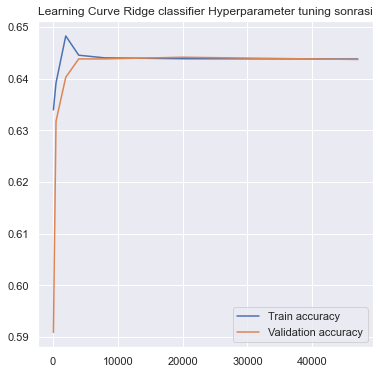

In [394]:
plt.plot(train_sizes, train_mean, label = 'Train accuracy')
plt.plot(train_sizes, validation_mean, label = 'Validation accuracy')
plt.legend(loc = 'best')
plt.title('Learning Curve Ridge classifier Hyperparameter tuning sonrasi')
plt.show()

* Bayes farkımız oldukça az 

## Feature engineerining ile accuracy yükseltimi

In [395]:
data_importance.head()

,EXT_SOURCE_2,AMT_CREDIT,EXT_SOURCE_3,LANDAREA_MODE,DAYS_ID_PUBLISH,YEARS_BEGINEXPLUATATION_AVG,BASEMENTAREA_MODE,APARTMENTS_MODE,OCCUPATION_TYPE,TARGET
0,-1.534899,-0.487614,-2.203967,-0.289702,0.445872,-1.411974,-0.680481,0.0252,0.022263,1
1,0.502203,1.923216,0.117096,-0.934544,1.644679,0.473259,-0.344697,0.0924,-1.075891,0
2,0.979491,-1.164723,0.242859,-0.525367,1.010209,0.911685,-0.123730,0.0284,0.022263,0
3,-0.433878,-0.240464,-0.916652,1.111341,0.185005,-0.476665,0.277043,0.0924,1.340047,0
4,0.667530,-0.981241,-0.315539,0.052142,-0.060787,-0.549736,-1.178740,0.0735,-1.515152,0


In [396]:
data_importance.shape

(35525, 10)

In [457]:
data_importance['EXT_SOURCE_MED'] = data_importance['EXT_SOURCE_2'] / data_importance['EXT_SOURCE_3']
data_importance['MODE_DOT'] = data_importance['BASEMENTAREA_MODE']*data_importance['APARTMENTS_MODE']

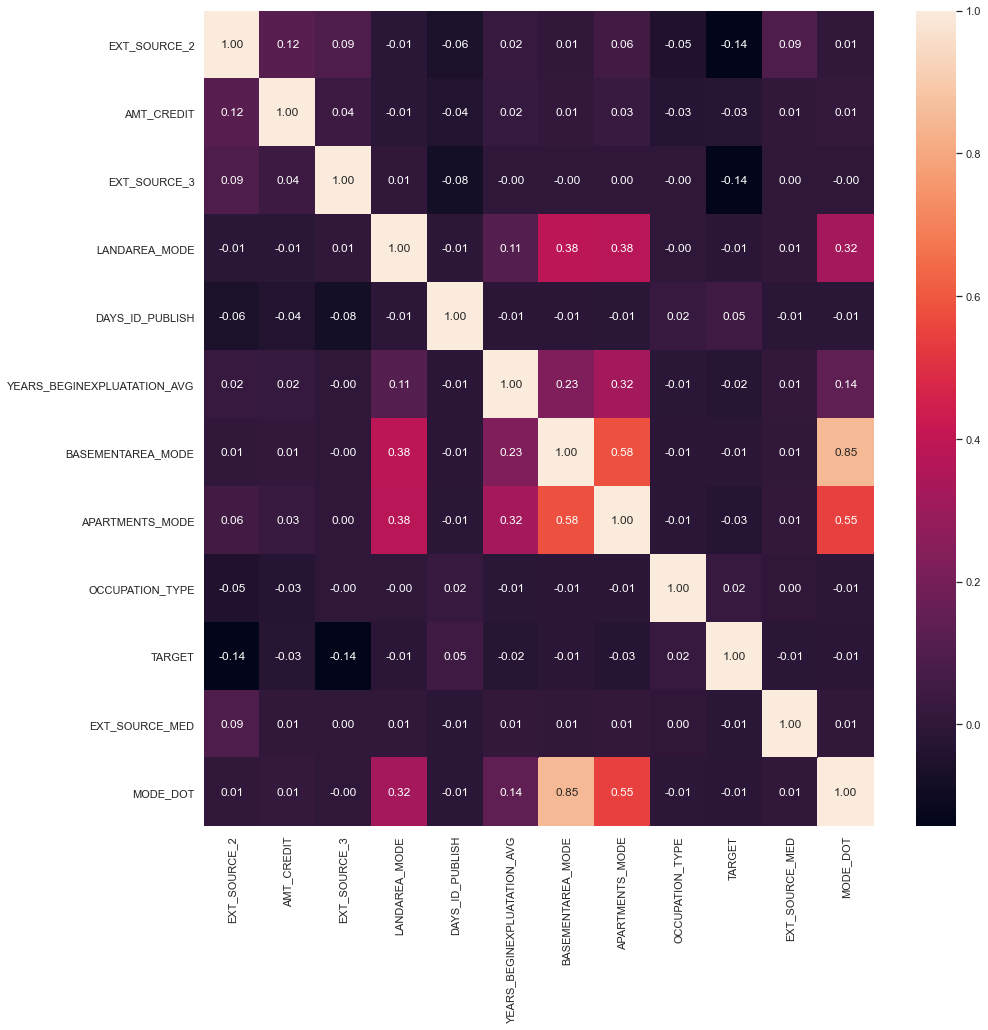

In [458]:
# extract edilen featureların korelasyonlarının kontrolü 
plt.figure(figsize=(15,15))
sns.heatmap(data_importance.corr(), annot = True, fmt = '0.2f')
plt.show()

In [459]:
data_importance.shape

(35525, 12)

In [460]:
y.shape

(35525,)

In [461]:
X_feature_ext = data_importance.drop('TARGET', axis = 1)
y_feature_ext = data_importance['TARGET']

In [462]:
X_feature_ext, y_feature_ext = sm.fit_resample(X_feature_ext,y_feature_ext.ravel())

In [463]:
X_train_importance, X_test_importance, y_train_importance, y_test_importance = train_test_split(X_feature_ext, y_feature_ext, 
                                                                                                test_size = 0.2, 
                                                                                                random_state = 42)

In [464]:
Counter(y_train_importance)

Counter({0: 26145, 1: 26055})

### LGBM classifier

In [466]:
# feature extraction sonrası hyperparameter tuning(lgbm için)
grid = {'num_leaves': [27, 31, 61, 81, 127, 197, 231, 275, 302],
        'bagging_fraction': [0.5, 0.7, 0.8, 0.9],
        'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5],
        'min_data': [300, 400, 450, 500, 550, 650],
        'is_unbalance': [True, False],
        'max_bin': [3, 5, 10, 12, 18, 20, 22],
        'boosting_type' : ['gbdt', 'dart'],
        'bagging_freq': [3, 9, 11, 15, 17, 23, 31],
        'max_depth': [3, 4, 5, 6, 7, 9, 11] }

rs = RandomizedSearchCV(lgbm , grid , cv = 10)
rs.fit(X_train_importance, y_train_importance)

print('Best hyperparameter is : {}'.format(rs.best_params_))
print('Best validation score is : {}'.format(rs.best_score_))

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=650. Current value: min_data_in_leaf=650
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=650. Current value: min_data_in_leaf=650
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=650. Current value: min_data_in_leaf=650
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=650. Current value: min_data_in_leaf=650
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=650. Current value: min_data_in_leaf=650
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=650. Current value: min_data_in_leaf=650
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=400. Current value: min_data_in_leaf=400
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=550. Current value: min_data_in_leaf=550
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=550. Current value: min_data_in_leaf=550
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=550. Current value: min_data_in_leaf=550
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0

In [467]:
# After the hyperparameter tuning 
lgbm = LGBMClassifier(num_leaves = 231, min_data = 550, max_depth = 3, max_bin = 18, learning_rate = 0.05, 
                      is_unbalance = True, boosting_type = 'dart', bagging_freq = 23, bagging_fraction = 0.7)

In [468]:
lgbm.fit(X_train_importance, y_train_importance)
print('Acc LGBM After the feature extraction: ', lgbm.score(X_test_importance, y_test_importance))

Acc LGBM After the feature extraction:  0.704367816091954


In [491]:
from sklearn.model_selection import learning_curve
# for train sizes list
train_sizes = np.linspace(0.1,1,5)

train_sizes, train_score, validation_score = learning_curve(lgbm, X_train_importance, y_train_importance, 
                                                                           cv = 10, scoring = 'accuracy', 
                                                                           train_sizes = train_sizes)
print(train_score)
print('-' * 70)
print(validation_score)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=550. Current value: min_data_in_leaf=550
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=550. Current value: min_data_in_leaf=550
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=550. Current value: min_data_in_leaf=550
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=550. Current value: min_data_in_leaf=550
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=550. Current value: min_data_in_leaf=550
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=550. Current value: min_data_in_leaf=550
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=550. Current value: min_data_in_leaf=550
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=550. Current value: min_data_in_leaf=550
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=550. Current value: min_data_in_leaf=550
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0

In [492]:
print(classification_report(lgbm.predict(X_test_importance), y_test_importance))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      6102
           1       0.74      0.70      0.71      6948

    accuracy                           0.70     13050
   macro avg       0.70      0.71      0.70     13050
weighted avg       0.71      0.70      0.70     13050



In [493]:
train_mean = np.mean(train_score, axis = 1)
train_mean

array([0.67420179, 0.69199633, 0.69529394, 0.70064544, 0.70040017])

In [494]:
validation_mean = np.mean(validation_score, axis = 1)
validation_mean

array([0.66555556, 0.69273946, 0.69295019, 0.69917625, 0.69944444])

* Hyperparameter tuning sonrası acc'miz ciddi manada yükseldi ve daha optimize bir sonuç aldık.

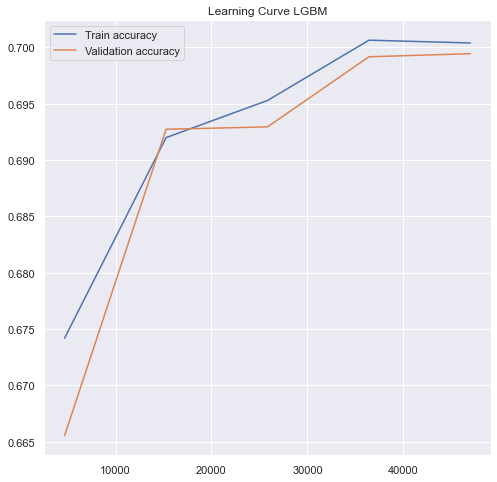

In [496]:
sns.set(rc={'figure.figsize':(8 , 8)})
plt.plot(train_sizes, train_mean, label = 'Train accuracy')
plt.plot(train_sizes, validation_mean, label = 'Validation accuracy')
plt.legend(loc = 'best')
plt.title('Learning Curve LGBM')
plt.show()

### RidgeClassifier

In [497]:
rc = RidgeClassifier()

In [502]:
# hyperparameters 
grid = {'alpha': [1.0, 4.0, 16.0],
        'fit_intercept': [True, False],
        'normalize':  [True, False],
        'copy_X': [True, False],
        'class_weight': ['dict','balanced'],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

# hyperparameters tuning
rs = RandomizedSearchCV(rc , grid , cv = 10)
rs.fit(X_train_importance, y_train_importance)
print('Best hyperparameter is : {}'.format(rs.best_params_))
print('Best validation score is : {}'.format(rs.best_score_))

Best hyperparameter is : {'solver': 'sparse_cg', 'normalize': False, 'fit_intercept': False, 'copy_X': False, 'class_weight': 'balanced', 'alpha': 1.0}
Best validation score is : 0.6436015325670498


In [503]:
rc = RidgeClassifier(solver = 'sparse_cg', normalize = False, fit_intercept = False, copy_X =  False, 
                     class_weight = 'balanced', alpha = 1.0)

In [504]:
rc.fit(X_train_importance, y_train_importance)
print(rc.score(X_test_importance, y_test_importance))
print(classification_report(rc.predict(X_test_importance), y_test_importance))

0.6499616858237548
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      6632
           1       0.64      0.66      0.65      6418

    accuracy                           0.65     13050
   macro avg       0.65      0.65      0.65     13050
weighted avg       0.65      0.65      0.65     13050



In [512]:
from sklearn.model_selection import learning_curve
# for train sizes list
train_sizes = [1, 500, 2000, 4000, 8000, 20000, 46980]

train_sizes, train_score, validation_score = learning_curve(rc, X_train_importance, y_train_importance, 
                                                                           cv = 10, scoring = 'accuracy', 
                                                                           train_sizes = train_sizes)
print(train_score)
print('-' * 70)
print(validation_score)

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [0.628      0.618      0.618      0.618      0.618      0.618
  0.618      0.618      0.618      0.618     ]
 [0.6395     0.6455     0.6455     0.6455     0.6455     0.6455
  0.6455     0.6455     0.6455     0.6455    ]
 [0.6355     0.644      0.644      0.644      0.644      0.644
  0.644      0.644      0.644      0.644     ]
 [0.6315     0.638625   0.638125   0.638125   0.638125   0.638125
  0.638125   0.638125   0.638125   0.638125  ]
 [0.6398     0.6401     0.64045    0.63855    0.6349     0.6349
  0.6349     0.6349     0.6349     0.6349    ]
 [0.64438059 0.64508301 0.64489144 0.64448702 0.64229459 0.64316731
  0.64389102 0.64272031 0.64295445 0.64312473]]
----------------------------------------------------------------------
[[       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.6335249  0.62873563 0.62624521 0

In [513]:
train_mean = np.mean(train_score, axis = 1)
train_mean

array([1.        , 0.619     , 0.6449    , 0.64315   , 0.6375125 ,
       0.63683   , 0.64369945])

In [514]:
validation_mean = np.mean(validation_score, axis = 1)
validation_mean

array([       nan, 0.63630268, 0.63867816, 0.64344828, 0.64333333,
       0.64302682, 0.64360153])

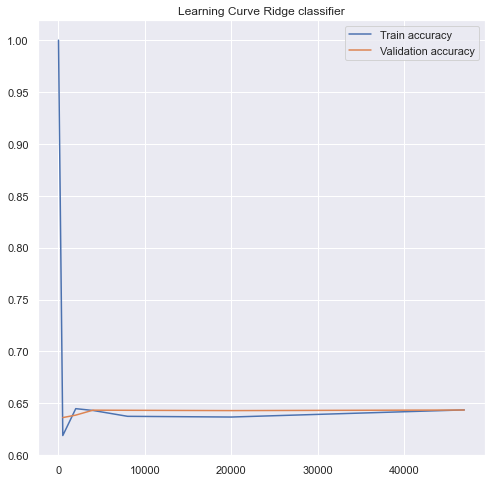

In [515]:
sns.set(rc={'figure.figsize':(8 , 8)})
plt.plot(train_sizes, train_mean, label = 'Train accuracy')
plt.plot(train_sizes, validation_mean, label = 'Validation accuracy')
plt.legend(loc = 'best')
plt.title('Learning Curve Ridge classifier')
plt.show()